In [30]:
import json
import pandas as pd
from src.config import REPORTS_DIR
from src.dipstick_clf.read.utils import REFERENCE_VALUES

uci_cols = ["glu", "sg", "ph", "nit", "leu"]
pad_cols = ["uro", "glu", "bil", "ket", "sg", "bld", "ph", "pro", "nit", "leu"]
REFERENCE_VALUES = {new: REFERENCE_VALUES[old] for new, old in zip(pad_cols, REFERENCE_VALUES.keys())}
DIPSTICK_READ_DIR = REPORTS_DIR / "dipstick_read"

In [31]:
def parse_json(filename):
    """Parse model readings JSON into pad values."""

    with open(DIPSTICK_READ_DIR / filename, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    flattened = []
    for entry in data:
        row = {'image': entry['image']}
        for test, values in entry['results'].items():
            for key, val in values.items():
                row[f"{test}_{key}"] = val
        flattened.append(row)

    df = pd.DataFrame(flattened)
    val_df = df[[col for col in df.columns if 'image' in col or 'value' in col]].copy()
    val_df.columns = ["img", "uro", "glu", "bil", "ket", "sg", "bld", "ph", "pro", "nit", "leu"]
    val_df["img"] = val_df["img"].str.extract(r'(\d+)').astype(int)
    val_df = val_df.sort_values(by=["img"], axis=0)
    val_df["img"] = "t" + val_df["img"].astype(str)
    val_df = val_df.reset_index(drop=True)

    return val_df

def find_pos(df):
    """Finds the normalised position of a result among reference values."""
    pos_df = df.copy()

    for col in pad_cols:
        refs = REFERENCE_VALUES[col] # type: ignore
        n_refs = len(refs)
        pos_df[col] = df[col].apply(lambda x: refs.index(x)/n_refs).round(2)

    return pos_df

def compute_deviations(human_df, model_df):
    """Find the normalised and raw deviations using the positions of choices."""

    pos_human_df = find_pos(human_df)
    pos_model_df = find_pos(model_df)

    norm_deviations = pos_human_df[pad_cols] - pos_model_df[pad_cols]
    norm_deviations["img"] = human_df["img"]
    norm_deviations = norm_deviations[["img"] + pad_cols]

    raw_deviations = norm_deviations[pad_cols].copy()
    for col in pad_cols:
        N = len(REFERENCE_VALUES[col]) # type: ignore
        raw_deviations[col] = (norm_deviations[col] * N).round().astype(int)
    raw_deviations["img"] = human_df["img"]
    raw_deviations = raw_deviations[["img"] + pad_cols]
    
    return norm_deviations, raw_deviations

def deviation_probabilities(deviation_df):
    """Compute the probability of deviation."""
    deviation_probs = (deviation_df[pad_cols] != 0).mean()
    deviation_probs = deviation_probs.reset_index()
    deviation_probs.columns = ["analyte", "prob"]

    return deviation_probs

def mean_acc(df):
    """Compute mean accuracy per analyte across all samples"""
    mean_df = df[pad_cols].mean().reset_index()
    mean_df.columns = ["analyte", "mean_acc"]
    mean_df["std"] = df[pad_cols].std().reset_index(drop=True)
    mean_df["std"] = mean_df["std"].round(2)

    return mean_df

In [ ]:
SAMPLING_METHODS = {
    1: ["grid", "Grid Based"],
    2: ["cw", "Centre Weighted"],
    3: ["full", "Full"]
}
SELECTION = 3
SAMPLING_METHOD = SAMPLING_METHODS[SELECTION]

In [33]:
human_df = pd.read_csv(DIPSTICK_READ_DIR / "human_readings_no_aug.csv").astype(str)
human_df["sg"] = human_df["sg"].apply(lambda x: x + "0")
model_df = parse_json(f"model_readings_no_aug({SAMPLING_METHOD[0]}).json")

In [34]:
#human_df
#model_df

In [35]:
acc_df = (human_df == model_df).astype(int)
acc_df["img"] = human_df["img"]
#acc_df

In [36]:
total_acc_means = mean_acc(acc_df)
uci_acc_means = total_acc_means[total_acc_means["analyte"].isin(uci_cols)]
#total_acc_means

In [37]:
total_acc = acc_df[pad_cols].values.mean()
uci_acc = acc_df[uci_cols].values.mean()

print(f"Mean accuracy for all analytes: {total_acc}")
print(f"Mean accuracy for UCI ML Repo CKD analytes: {uci_acc}")

Mean accuracy for all analytes: 0.89
Mean accuracy for UCI ML Repo CKD analytes: 0.92


In [38]:
norm_deviations, raw_deviations = compute_deviations(human_df, model_df)
#norm_deviations

In [39]:
deviation_probs = deviation_probabilities(raw_deviations)
deviation_probs

,analyte,prob
0,uro,0.0
1,glu,0.2
2,bil,0.0
3,ket,0.0
4,sg,0.1
5,bld,0.6
6,ph,0.1
7,pro,0.1
8,nit,0.0
9,leu,0.0


## Plots

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/s0/f5rjt2b943x41srzy579gf8c0000gn/T/ipykernel_5067/3164167703.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(mean_dev.index, rotation=45)


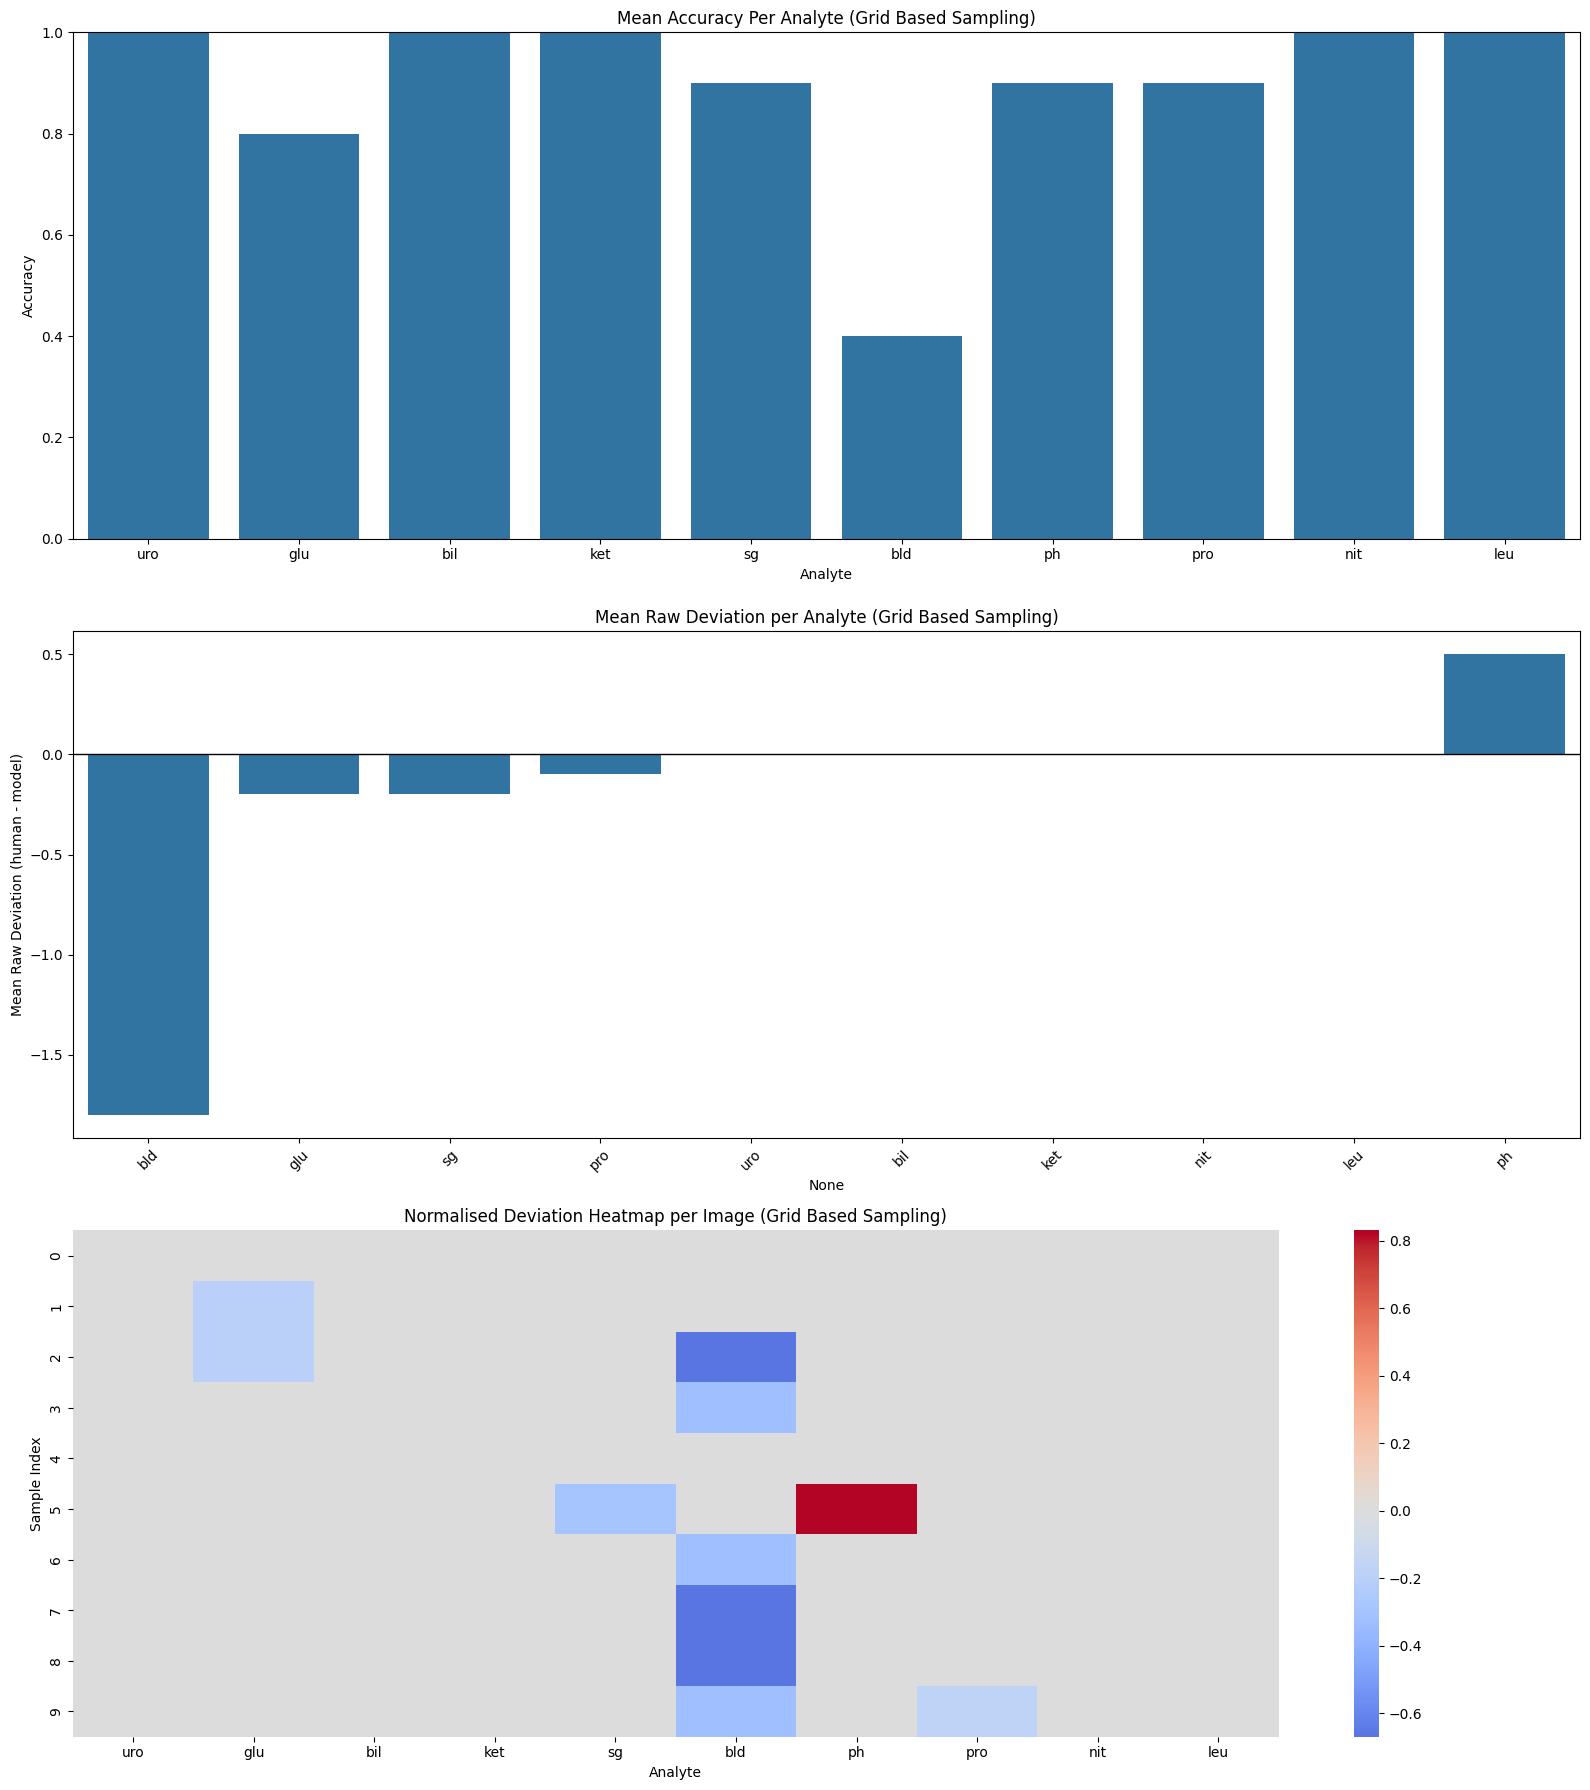

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(16, 18))

# Accuracy per analyte
sns.barplot(ax=axes[0], data=total_acc_means, x="analyte", y="mean_acc")
axes[0].set_title(f"Mean Accuracy Per Analyte ({SAMPLING_METHOD[1]} Sampling)")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("Analyte")
axes[0].set_ylim(0, 1)

# Mean raw deviation
mean_dev = raw_deviations[pad_cols].mean().sort_values()
sns.barplot(ax=axes[1], x=mean_dev.index, y=mean_dev.values)
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title(f"Mean Raw Deviation per Analyte ({SAMPLING_METHOD[1]} Sampling)")
axes[1].set_ylabel("Mean Raw Deviation (human - model)")
axes[1].set_xticklabels(mean_dev.index, rotation=45)

# Heatmap
sns.heatmap(
    norm_deviations[pad_cols],
    cmap="coolwarm",
    center=0,
    annot=False,
    ax=axes[2]
)
axes[2].set_title(f"Normalised Deviation Heatmap per Image ({SAMPLING_METHOD[1]} Sampling)")
axes[2].set_xlabel("Analyte")
axes[2].set_ylabel("Sample Index")

plt.tight_layout()
plt.show()

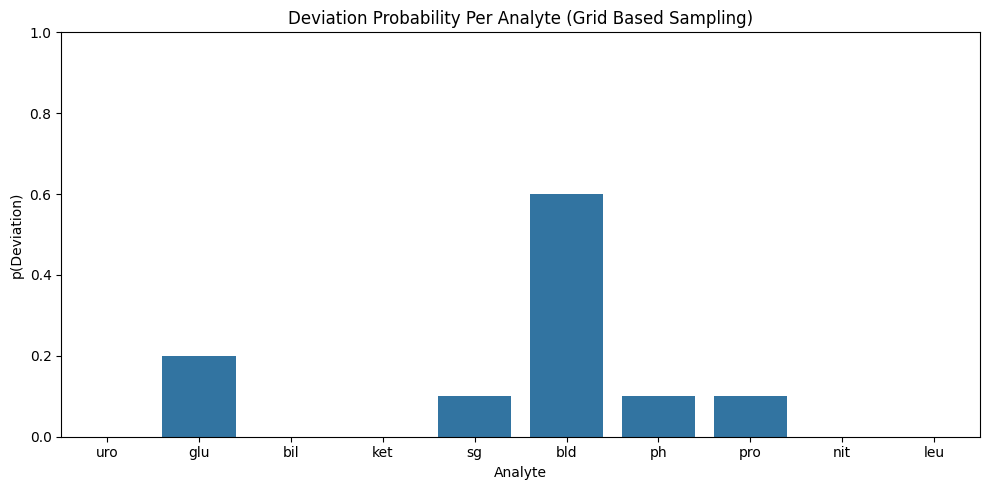

In [42]:
# Deviation probability per analyte
plt.figure(figsize=(10, 5))
sns.barplot(data=deviation_probs, x="analyte", y="prob")
plt.title(f"Deviation Probability Per Analyte ({SAMPLING_METHOD[1]} Sampling)")
plt.ylabel("p(Deviation)")
plt.xlabel("Analyte")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

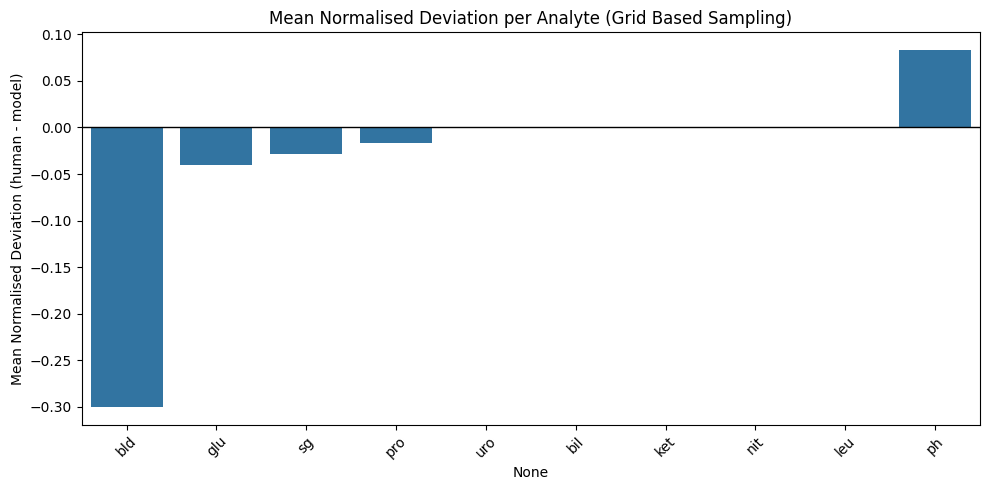

In [43]:
mean_dev = norm_deviations[pad_cols].mean().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=mean_dev.index, y=mean_dev.values)
plt.axhline(0, color="black", linewidth=1)
plt.title(f"Mean Normalised Deviation per Analyte ({SAMPLING_METHOD[1]} Sampling)")
plt.ylabel("Mean Normalised Deviation (human - model)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
